In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from copy import *
import scipy.io
from numpy.random import default_rng
import torch
import math

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37186626   0.03410609  -0.02927475]
 [-14.6399254    0.76926263  -0.53152977]
 [ 12.72441642   1.93685422  -1.37799719]]
B:  [[ 2.59990680e+00 -1.87191096e-01]
 [ 4.52996521e+02  4.98473431e+02]
 [ 6.58099508e+02  5.31718593e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value

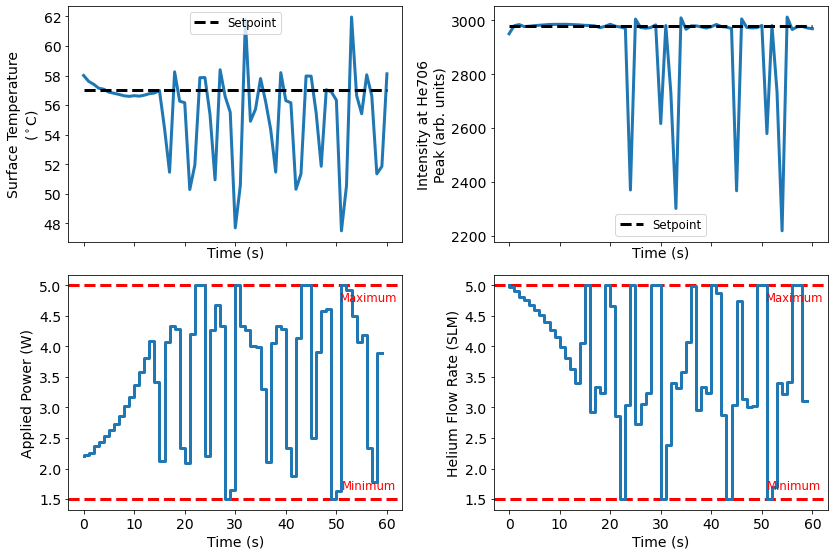

In [4]:
# import custom code
from config.my_system import get_prob_info
from utils.controller import OffsetFreeMPC, NominalMPC
from utils.simulation import Simulation
from utils.observer import EKF

def run_mpc(perc, plt_fig=False):
    # user inputs and options
    ts = 1.0 # sampling time, ensure it is the same as the model used
    Nsim = 60 # set the simulation horizon
    control_model_file = './models/APPJmodel_TEOS_UCB_LAM_modord3.mat'
    plant_model_file = './models/APPJmodel_TEOS_UCB_LAM_modord3.mat'

    Fontsize = 14 # default font size for plots
    Lwidth = 3 # default line width for plots
    lines = {'linewidth' : Lwidth}
    plt.rc('lines', **lines)
    font = {'family' : 'serif', 'serif'  : 'Times', 'size'   : Fontsize}
    plt.rc('font', **font)  # pass in the font dict as kwargs

    # [perc1, perc2, eps, seed] = perc ==> applying changes to A and B for plant
    
    # get problem information
    prob_info = get_prob_info(
        plant_model_file=plant_model_file, 
        control_model_file=control_model_file,
        perc=perc,
        filter_val=None, 
        mpc_type='offsetfree',
        )
    
    ts = prob_info['ts']
    xss = prob_info['xss']
    uss = prob_info['uss']
    xssp = prob_info['xssp']
    ussp = prob_info['ussp']
    x_min = prob_info['x_min']
    x_max = prob_info['x_max']
    u_min = prob_info['u_min']
    u_max = prob_info['u_max']
    
    print(prob_info['target_penalty'], " target penalty applied and exists")
    
    # get controller
    c = OffsetFreeMPC(prob_info)
    c.get_mpc()
    c.set_parameters([np.zeros((3,)), np.zeros((1,1)), np.zeros((1,1))])
    res, feas = c.solve_mpc()
    
    # get observer
    ekf = EKF(prob_info)
    ekf.get_observer()
    
    ## run closed loop simulation using MPC
    sim = Simulation(Nsim)
    sim.load_prob_info(prob_info)
    sim_data = sim.run_closed_loop(c, observer=ekf, offset=True, )
    
    ######### COLLECTING DATA ######### 
    ctime = sim_data['ctime']
    Yrefplot = sim_data['Yrefsim']
    Tref = Yrefplot[0,:] + xssp[0]
    I706ref = Yrefplot[1,:] + xssp[1]
    
    Tplot = sim_data['Ysim'][0,:] + xssp[0] # Temp
    I706 = sim_data['Ysim'][1,:] + xssp[1] # Intensity
    Pplot = sim_data['Usim'][0,:] + ussp[0] # Power
    qplot = sim_data['Usim'][1,:] + ussp[1] # Flowrate
    
    ######### PLOTTING ###########
    if plt_fig:
        fig, axes = plt.subplots(2,2, sharex=True, figsize=(12,8))
        
        axes[0,0].plot(np.arange(len(Tplot))*ts, Tplot)
        axes[0,0].plot(np.arange(len(Tref))*ts, Tref, 'k--', label='Setpoint')
        axes[0,0].legend(fontsize='small', loc='upper center')
        axes[0,0].set_xlabel('Time (s)')
        axes[0,0].set_ylabel('Surface Temperature\n('+r'$^\circ$'+'C)')

        axes[0,1].plot(np.arange(len(I706))*ts, I706)
        axes[0,1].plot(np.arange(len(I706))*ts, I706ref, 'k--', label='Setpoint')
        axes[0,1].legend(fontsize='small', loc='lower center')
        axes[0,1].set_xlabel('Time (s)')
        axes[0,1].set_ylabel('Intensity at He706\nPeak (arb. units)')

        axes[1,0].axhline(u_max[0]+uss[0], color='r', ls='--')
        axes[1,0].text(0.9, 0.9, 'Maximum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,0].transAxes,
                       color='r',
                       )
        axes[1,0].axhline(u_min[0]+uss[0], color='r', ls='--')
        axes[1,0].text(0.9, 0.1, 'Minimum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,0].transAxes,
                       color='r',
                       )
        axes[1,0].step(np.arange(len(Pplot))*ts, Pplot)
        axes[1,0].set_xlabel('Time (s)')
        axes[1,0].set_ylabel('Applied Power (W)')

        axes[1,1].axhline(u_max[1]+uss[1], color='r', ls='--')
        axes[1,1].text(0.9, 0.9, 'Maximum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,1].transAxes,
                       color='r',
                       )
        axes[1,1].axhline(u_min[1]+uss[1], color='r', ls='--')
        axes[1,1].text(0.9, 0.1, 'Minimum', fontsize='small',
                       horizontalalignment='center',
                       verticalalignment='center', 
                       transform=axes[1,1].transAxes,
                       color='r',
                       )
        axes[1,1].step(np.arange(len(qplot))*ts, qplot)
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].set_ylabel('Helium Flow Rate (SLM)')

        plt.tight_layout()
        plt.show()
        
    # Trajectory of the measurable variables
    Temp_traj = Tplot[:Nsim+1]
    Intensity_traj = I706[:Nsim+1]

    # TODO: automate constraint violation for larger number of measurable variables
    Temp_violation = np.sum(Tref - Temp_traj)**2
    Intensity_violation = np.sum(I706ref - Intensity_traj)**2
    
    return Temp_violation, Intensity_violation

perc1, perc2, eps, seed = 0.05, 0.02, 1e-3, 2500 
perc = [perc1, perc2, eps, seed]
T, I = run_mpc(perc, plt_fig=True)

0.0   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40188791   0.03410626  -0.02807356]
 [-14.43915966   0.78175365  -0.52417705]
 [ 12.55767361   1.99900198  -1.44077142]]
B:  [[ 2.57492690e+00 -1.84887907e-01]
 [ 4.48015674e+02  4.91628563e+02]
 [ 6.45834714e+02  5.28702898e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


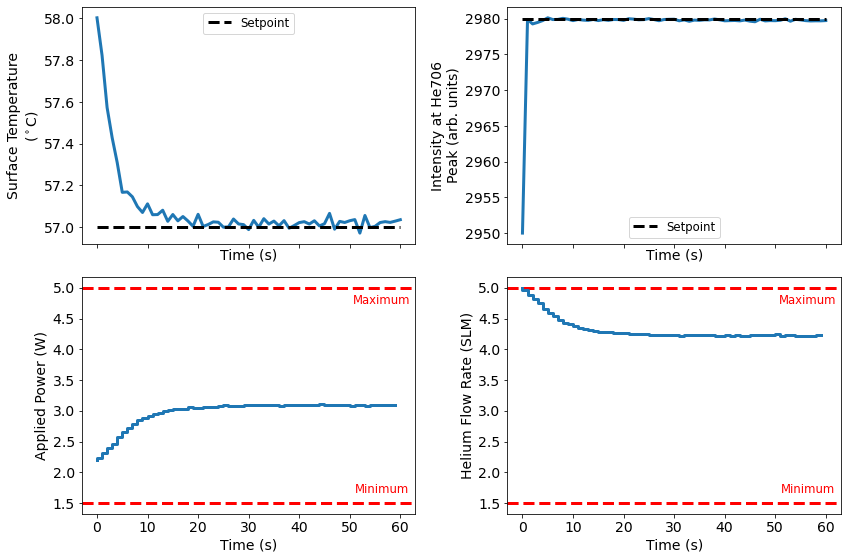



0.0   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40188791   0.03410626  -0.02807356]
 [-14.43915966   0.78175365  -0.52417705]
 [ 12.55767361   1.99900198  -1.44077142]]
B:  [[ 2.58741685e+00 -1.86039501e-01]
 [ 4.50506098e+02  4.95050997e+02]
 [ 6.51967111e+02  5.30210746e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


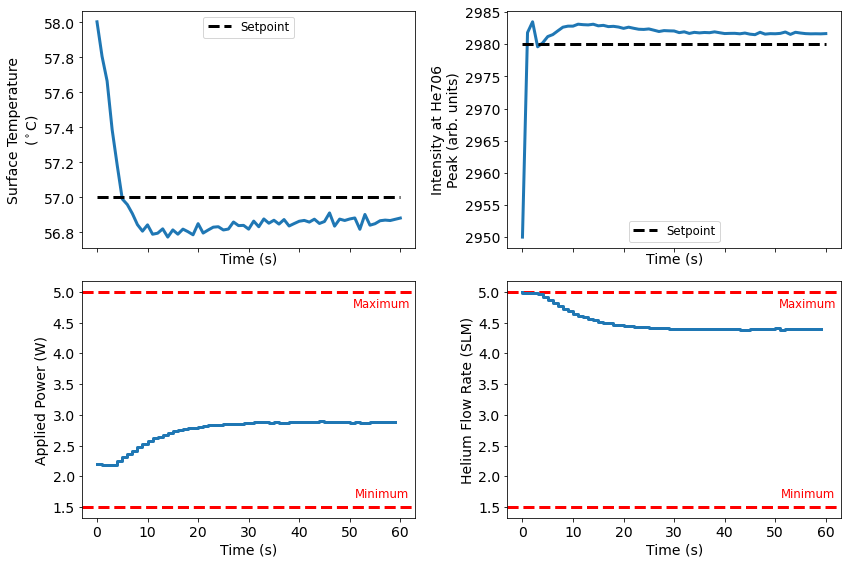



0.0   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40188791   0.03410626  -0.02807356]
 [-14.43915966   0.78175365  -0.52417705]
 [ 12.55767361   1.99900198  -1.44077142]]
B:  [[ 2.59990680e+00 -1.87191096e-01]
 [ 4.52996521e+02  4.98473431e+02]
 [ 6.58099508e+02  5.31718593e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


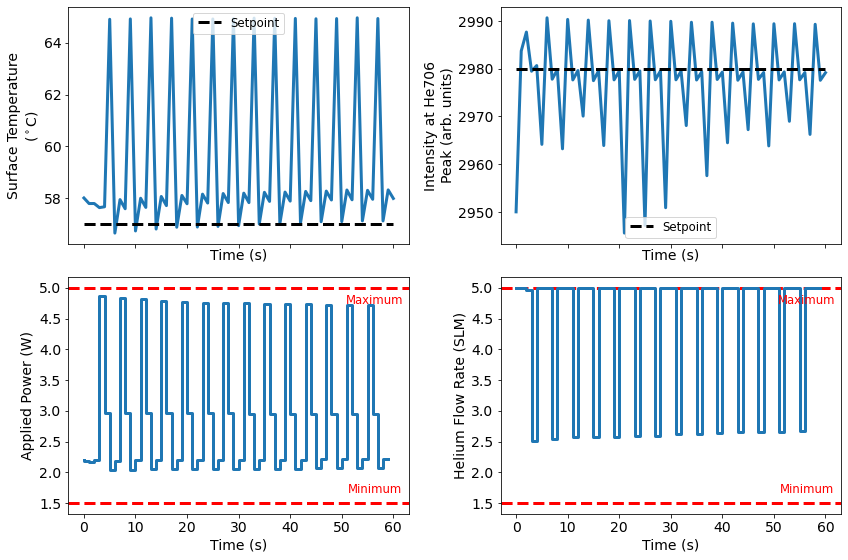



0.0   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40188791   0.03410626  -0.02807356]
 [-14.43915966   0.78175365  -0.52417705]
 [ 12.55767361   1.99900198  -1.44077142]]
B:  [[ 2.61239676e+00 -1.88342690e-01]
 [ 4.55486945e+02  5.01895865e+02]
 [ 6.64231905e+02  5.33226440e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


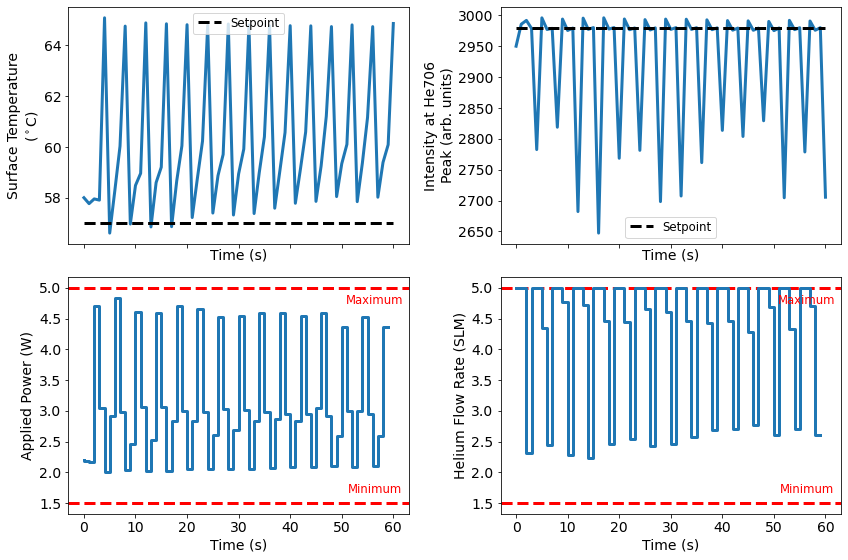



0.0   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40188791   0.03410626  -0.02807356]
 [-14.43915966   0.78175365  -0.52417705]
 [ 12.55767361   1.99900198  -1.44077142]]
B:  [[ 2.62488671e+00 -1.89494284e-01]
 [ 4.57977369e+02  5.05318299e+02]
 [ 6.70364302e+02  5.34734288e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


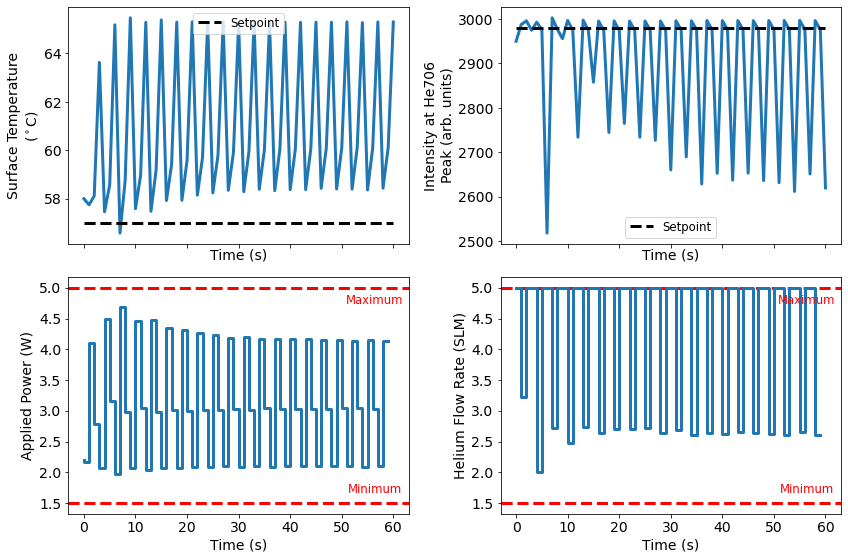



0.0   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40188791   0.03410626  -0.02807356]
 [-14.43915966   0.78175365  -0.52417705]
 [ 12.55767361   1.99900198  -1.44077142]]
B:  [[ 2.63737666e+00 -1.90645878e-01]
 [ 4.60467792e+02  5.08740733e+02]
 [ 6.76496699e+02  5.36242135e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use o

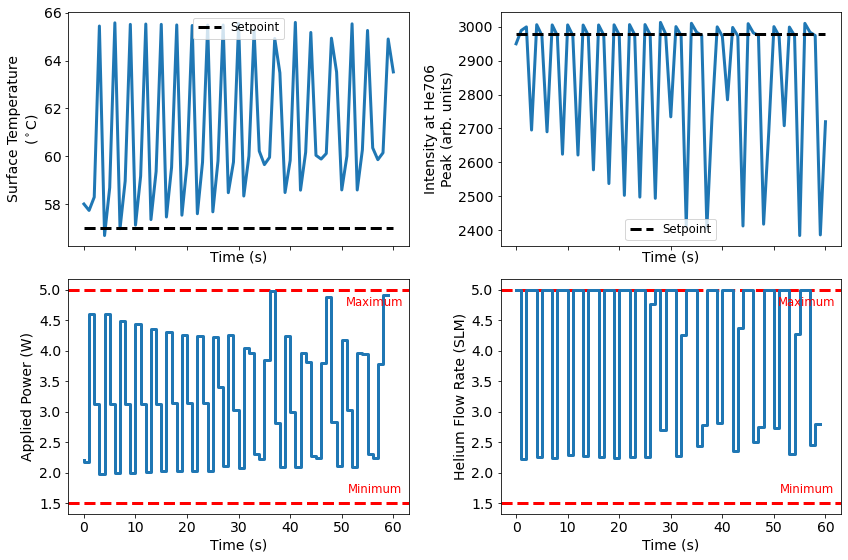



0.01   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39588358   0.03410622  -0.0283138 ]
 [-14.47931281   0.77925545  -0.52564759]
 [ 12.59102217   1.98657243  -1.42821657]]
B:  [[ 2.57492690e+00 -1.84887907e-01]
 [ 4.48015674e+02  4.91628563e+02]
 [ 6.45834714e+02  5.28702898e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


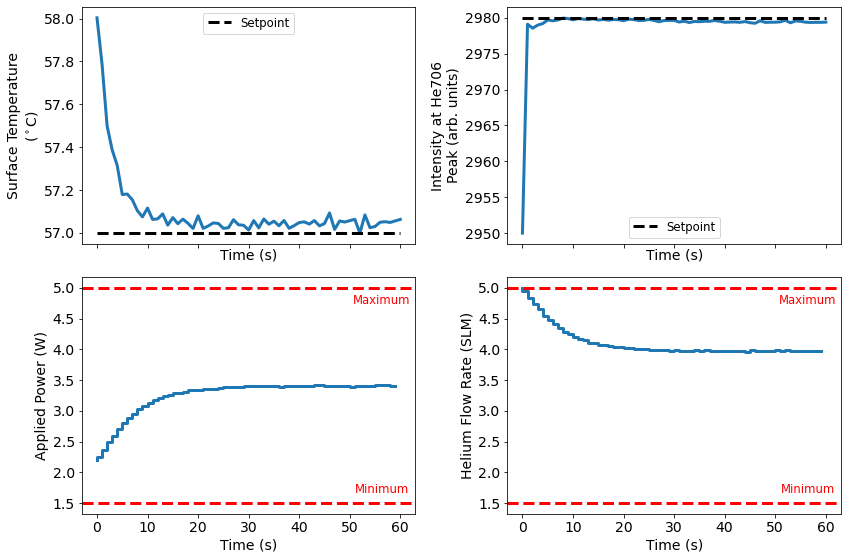



0.01   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39588358   0.03410622  -0.0283138 ]
 [-14.47931281   0.77925545  -0.52564759]
 [ 12.59102217   1.98657243  -1.42821657]]
B:  [[ 2.58741685e+00 -1.86039501e-01]
 [ 4.50506098e+02  4.95050997e+02]
 [ 6.51967111e+02  5.30210746e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


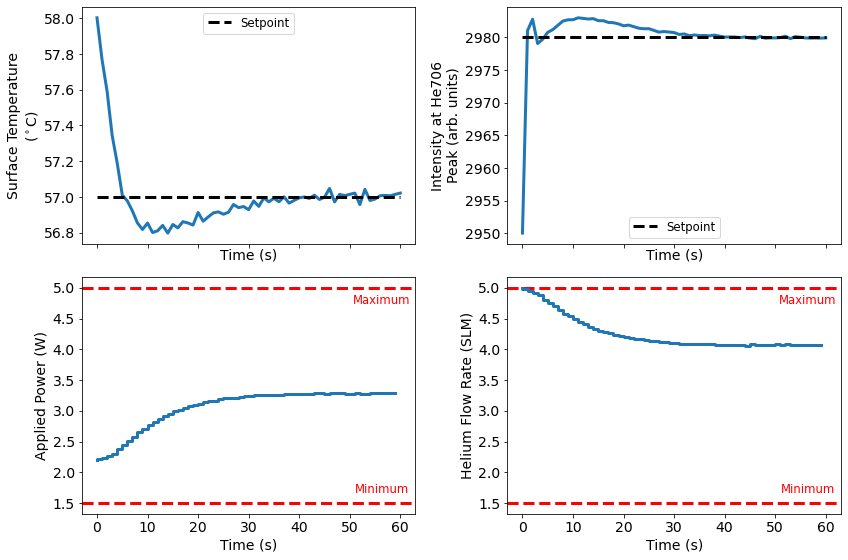



0.01   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39588358   0.03410622  -0.0283138 ]
 [-14.47931281   0.77925545  -0.52564759]
 [ 12.59102217   1.98657243  -1.42821657]]
B:  [[ 2.59990680e+00 -1.87191096e-01]
 [ 4.52996521e+02  4.98473431e+02]
 [ 6.58099508e+02  5.31718593e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


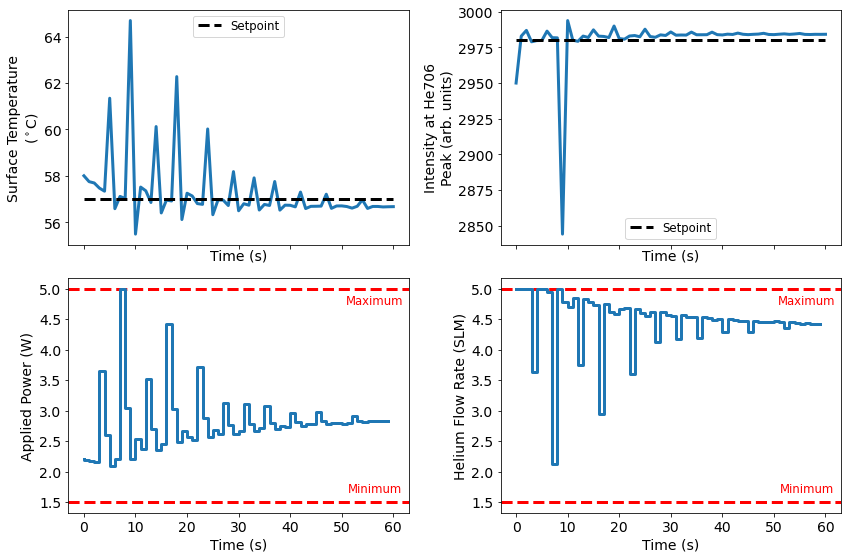



0.01   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39588358   0.03410622  -0.0283138 ]
 [-14.47931281   0.77925545  -0.52564759]
 [ 12.59102217   1.98657243  -1.42821657]]
B:  [[ 2.61239676e+00 -1.88342690e-01]
 [ 4.55486945e+02  5.01895865e+02]
 [ 6.64231905e+02  5.33226440e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


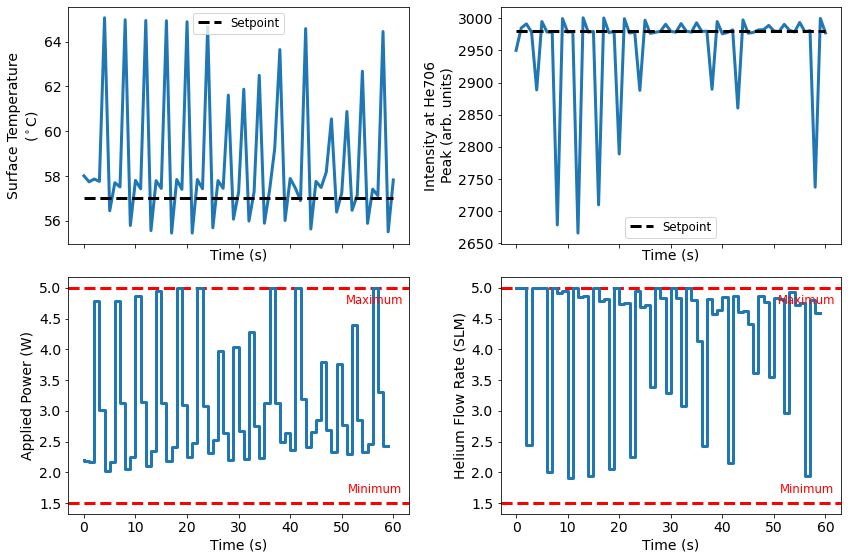



0.01   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39588358   0.03410622  -0.0283138 ]
 [-14.47931281   0.77925545  -0.52564759]
 [ 12.59102217   1.98657243  -1.42821657]]
B:  [[ 2.62488671e+00 -1.89494284e-01]
 [ 4.57977369e+02  5.05318299e+02]
 [ 6.70364302e+02  5.34734288e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

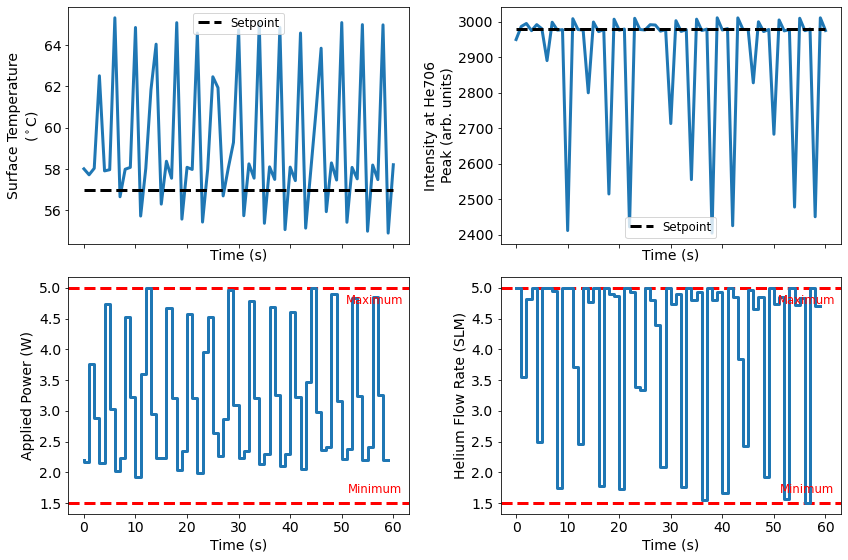



0.01   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.39588358   0.03410622  -0.0283138 ]
 [-14.47931281   0.77925545  -0.52564759]
 [ 12.59102217   1.98657243  -1.42821657]]
B:  [[ 2.63737666e+00 -1.90645878e-01]
 [ 4.60467792e+02  5.08740733e+02]
 [ 6.76496699e+02  5.36242135e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

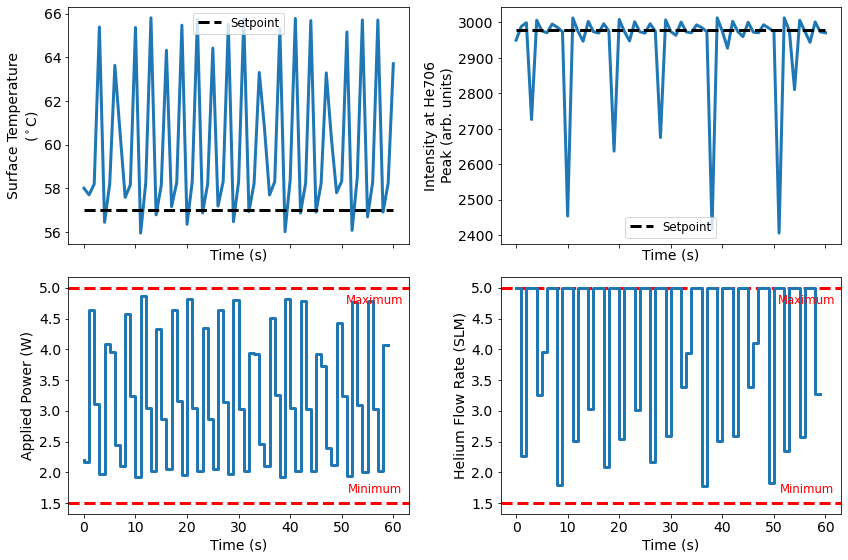



0.02   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38987925   0.03410619  -0.02855404]
 [-14.51946596   0.77675724  -0.52711814]
 [ 12.62437073   1.97414288  -1.41566173]]
B:  [[ 2.57492690e+00 -1.84887907e-01]
 [ 4.48015674e+02  4.91628563e+02]
 [ 6.45834714e+02  5.28702898e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


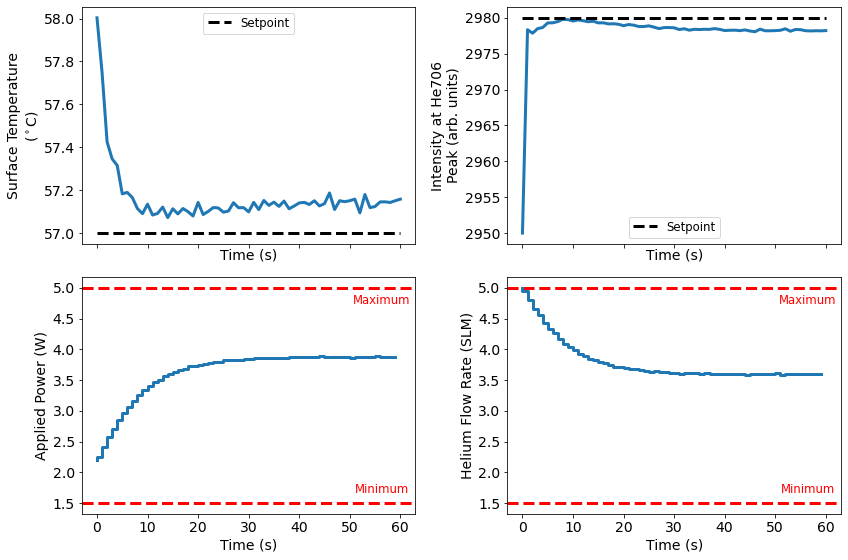



0.02   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38987925   0.03410619  -0.02855404]
 [-14.51946596   0.77675724  -0.52711814]
 [ 12.62437073   1.97414288  -1.41566173]]
B:  [[ 2.58741685e+00 -1.86039501e-01]
 [ 4.50506098e+02  4.95050997e+02]
 [ 6.51967111e+02  5.30210746e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


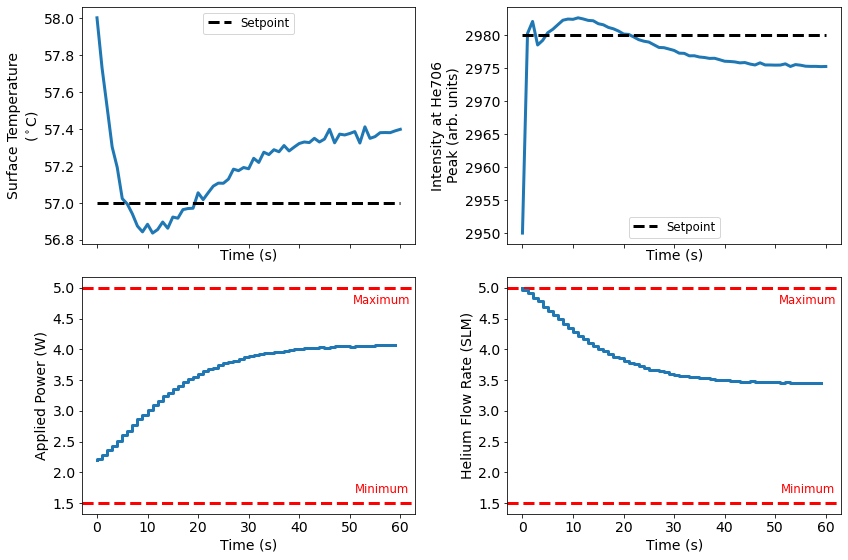



0.02   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38987925   0.03410619  -0.02855404]
 [-14.51946596   0.77675724  -0.52711814]
 [ 12.62437073   1.97414288  -1.41566173]]
B:  [[ 2.59990680e+00 -1.87191096e-01]
 [ 4.52996521e+02  4.98473431e+02]
 [ 6.58099508e+02  5.31718593e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


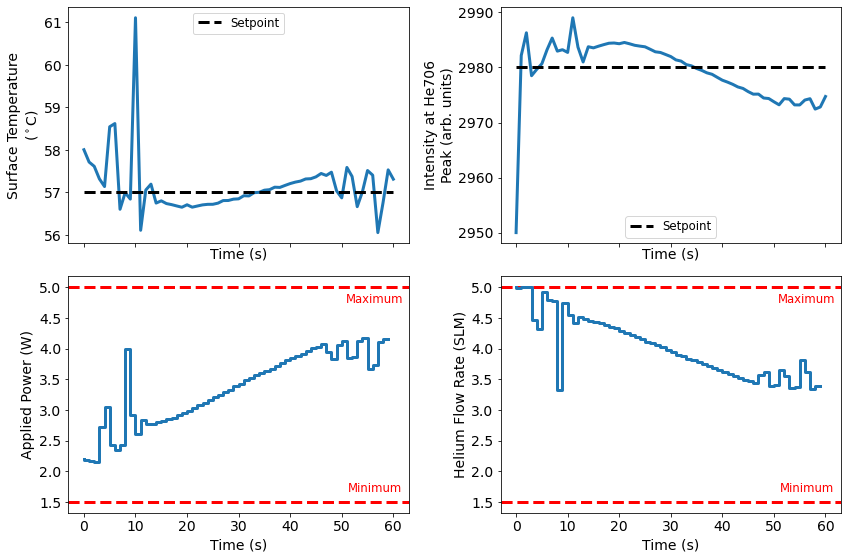



0.02   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38987925   0.03410619  -0.02855404]
 [-14.51946596   0.77675724  -0.52711814]
 [ 12.62437073   1.97414288  -1.41566173]]
B:  [[ 2.61239676e+00 -1.88342690e-01]
 [ 4.55486945e+02  5.01895865e+02]
 [ 6.64231905e+02  5.33226440e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


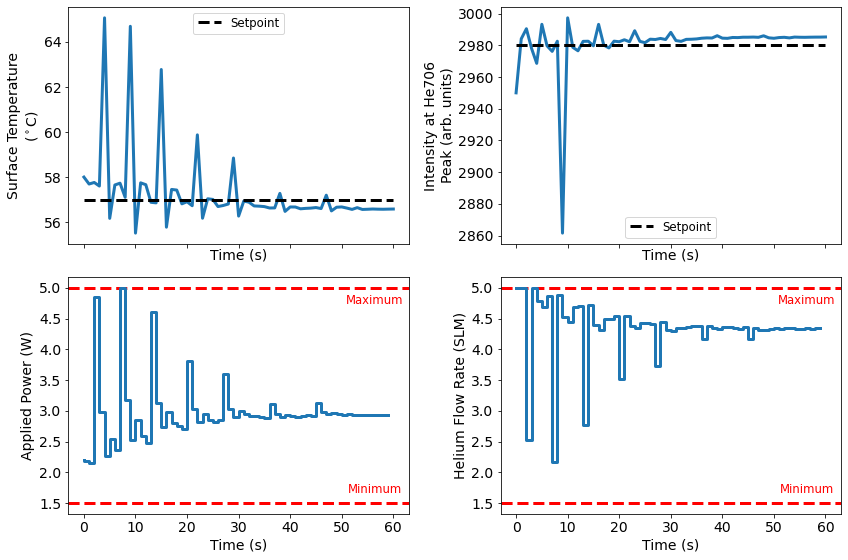



0.02   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38987925   0.03410619  -0.02855404]
 [-14.51946596   0.77675724  -0.52711814]
 [ 12.62437073   1.97414288  -1.41566173]]
B:  [[ 2.62488671e+00 -1.89494284e-01]
 [ 4.57977369e+02  5.05318299e+02]
 [ 6.70364302e+02  5.34734288e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


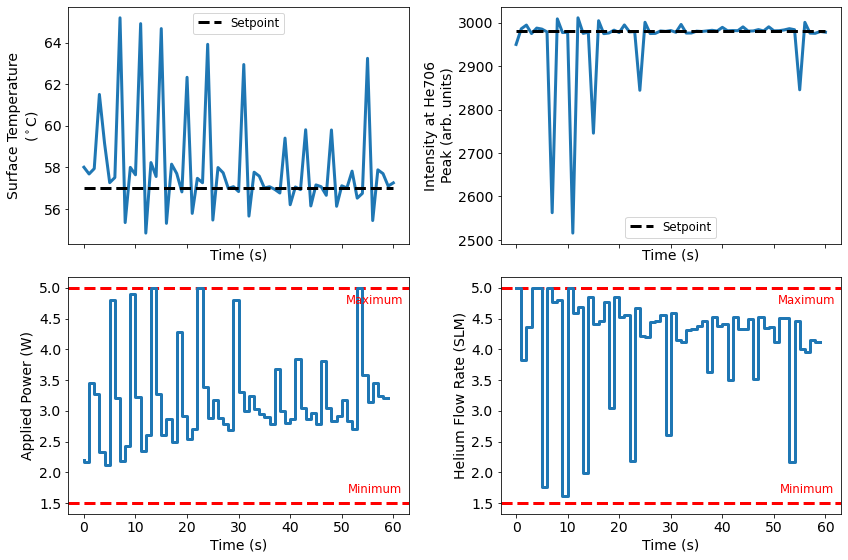



0.02   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38987925   0.03410619  -0.02855404]
 [-14.51946596   0.77675724  -0.52711814]
 [ 12.62437073   1.97414288  -1.41566173]]
B:  [[ 2.63737666e+00 -1.90645878e-01]
 [ 4.60467792e+02  5.08740733e+02]
 [ 6.76496699e+02  5.36242135e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

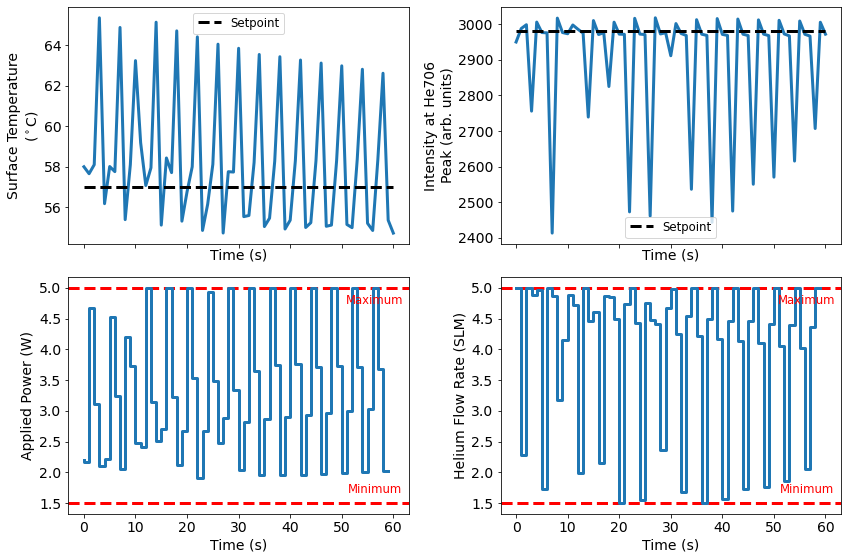



0.03   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38387492   0.03410615  -0.02879427]
 [-14.5596191    0.77425904  -0.52858868]
 [ 12.65771929   1.96171333  -1.40310688]]
B:  [[ 2.57492690e+00 -1.84887907e-01]
 [ 4.48015674e+02  4.91628563e+02]
 [ 6.45834714e+02  5.28702898e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


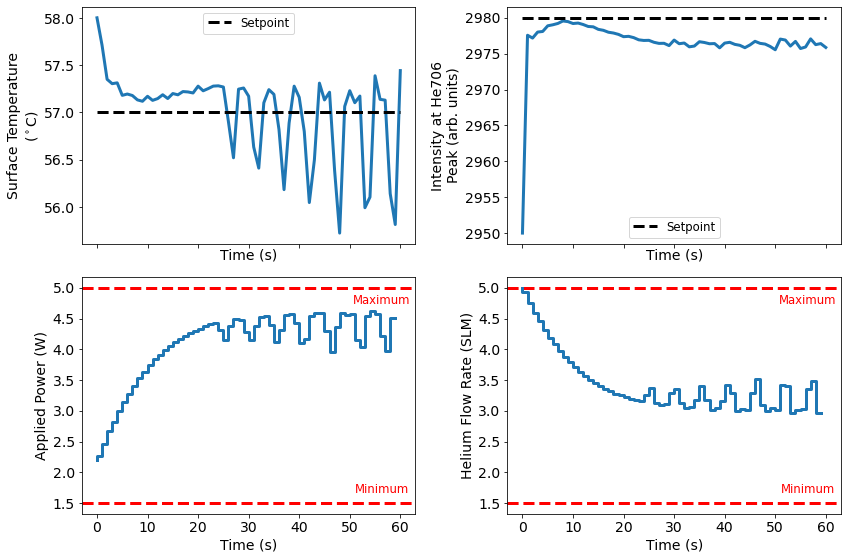



0.03   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38387492   0.03410615  -0.02879427]
 [-14.5596191    0.77425904  -0.52858868]
 [ 12.65771929   1.96171333  -1.40310688]]
B:  [[ 2.58741685e+00 -1.86039501e-01]
 [ 4.50506098e+02  4.95050997e+02]
 [ 6.51967111e+02  5.30210746e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


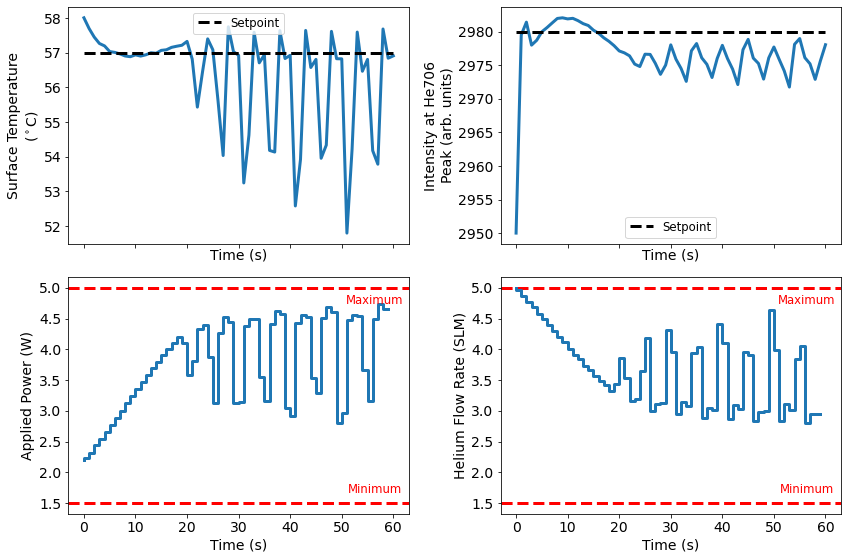



0.03   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38387492   0.03410615  -0.02879427]
 [-14.5596191    0.77425904  -0.52858868]
 [ 12.65771929   1.96171333  -1.40310688]]
B:  [[ 2.59990680e+00 -1.87191096e-01]
 [ 4.52996521e+02  4.98473431e+02]
 [ 6.58099508e+02  5.31718593e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


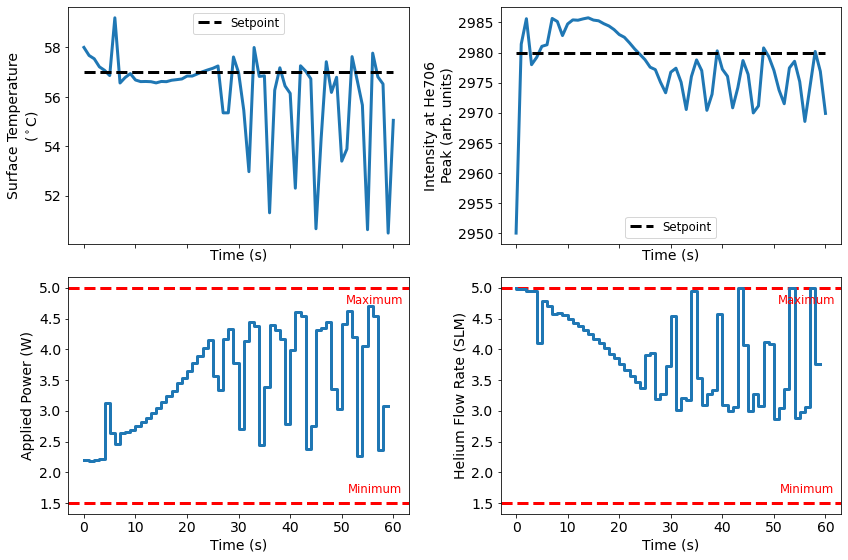



0.03   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38387492   0.03410615  -0.02879427]
 [-14.5596191    0.77425904  -0.52858868]
 [ 12.65771929   1.96171333  -1.40310688]]
B:  [[ 2.61239676e+00 -1.88342690e-01]
 [ 4.55486945e+02  5.01895865e+02]
 [ 6.64231905e+02  5.33226440e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


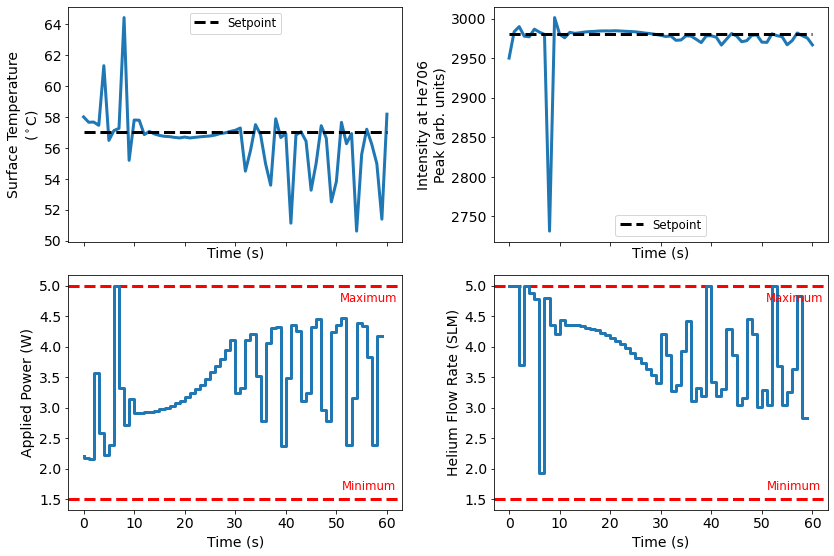



0.03   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38387492   0.03410615  -0.02879427]
 [-14.5596191    0.77425904  -0.52858868]
 [ 12.65771929   1.96171333  -1.40310688]]
B:  [[ 2.62488671e+00 -1.89494284e-01]
 [ 4.57977369e+02  5.05318299e+02]
 [ 6.70364302e+02  5.34734288e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


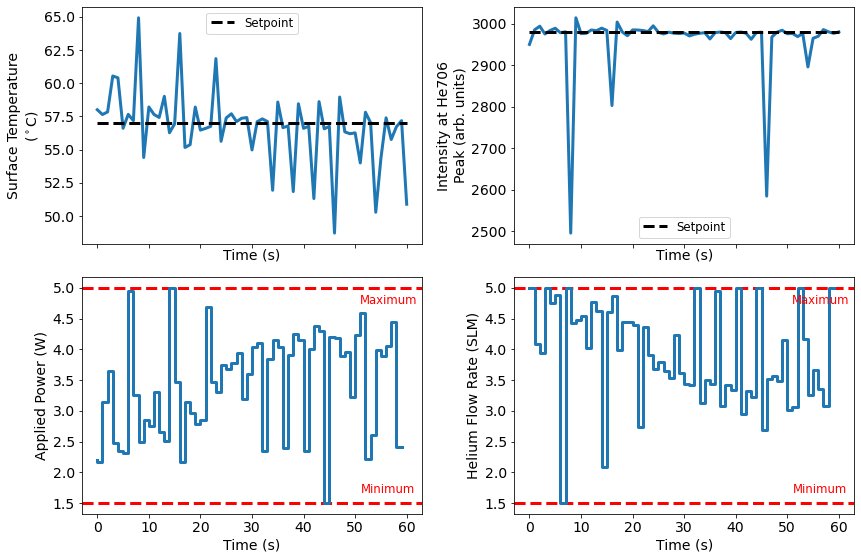



0.03   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.38387492   0.03410615  -0.02879427]
 [-14.5596191    0.77425904  -0.52858868]
 [ 12.65771929   1.96171333  -1.40310688]]
B:  [[ 2.63737666e+00 -1.90645878e-01]
 [ 4.60467792e+02  5.08740733e+02]
 [ 6.76496699e+02  5.36242135e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

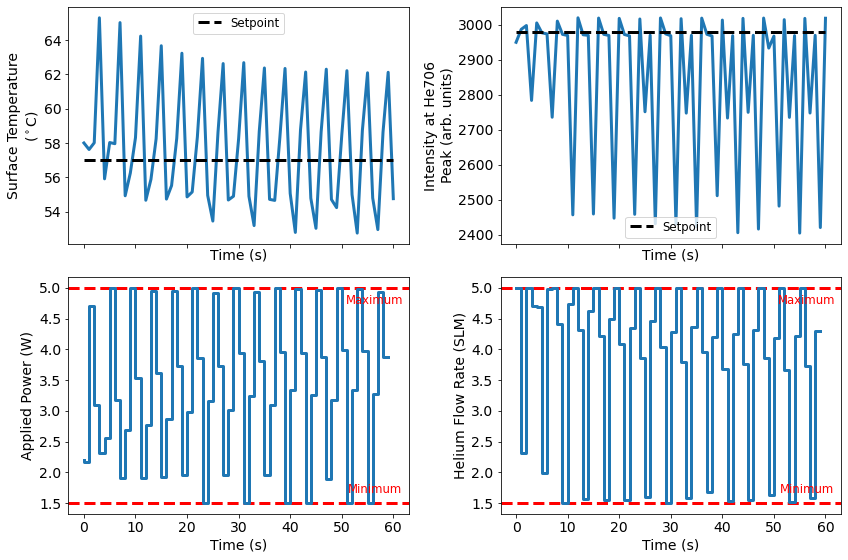



0.04   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37787059   0.03410612  -0.02903451]
 [-14.59977225   0.77176083  -0.53005923]
 [ 12.69106785   1.94928377  -1.39055204]]
B:  [[ 2.57492690e+00 -1.84887907e-01]
 [ 4.48015674e+02  4.91628563e+02]
 [ 6.45834714e+02  5.28702898e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


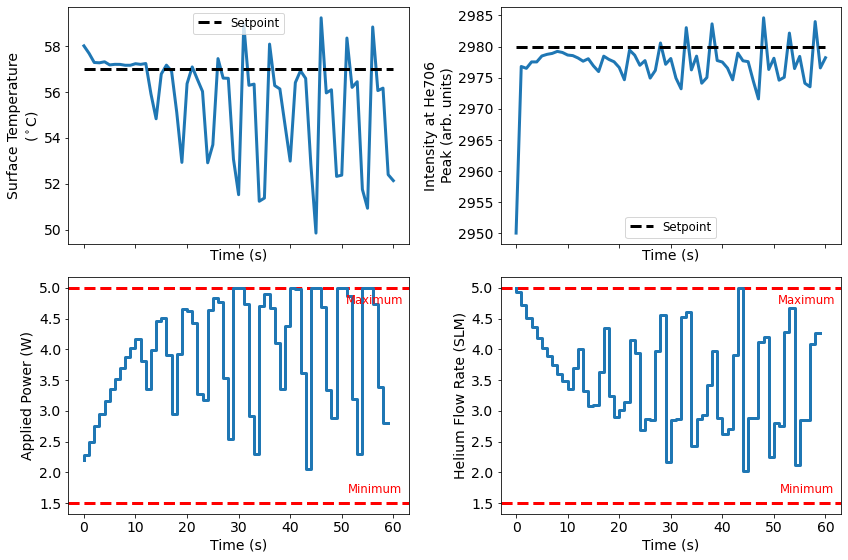



0.04   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37787059   0.03410612  -0.02903451]
 [-14.59977225   0.77176083  -0.53005923]
 [ 12.69106785   1.94928377  -1.39055204]]
B:  [[ 2.58741685e+00 -1.86039501e-01]
 [ 4.50506098e+02  4.95050997e+02]
 [ 6.51967111e+02  5.30210746e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


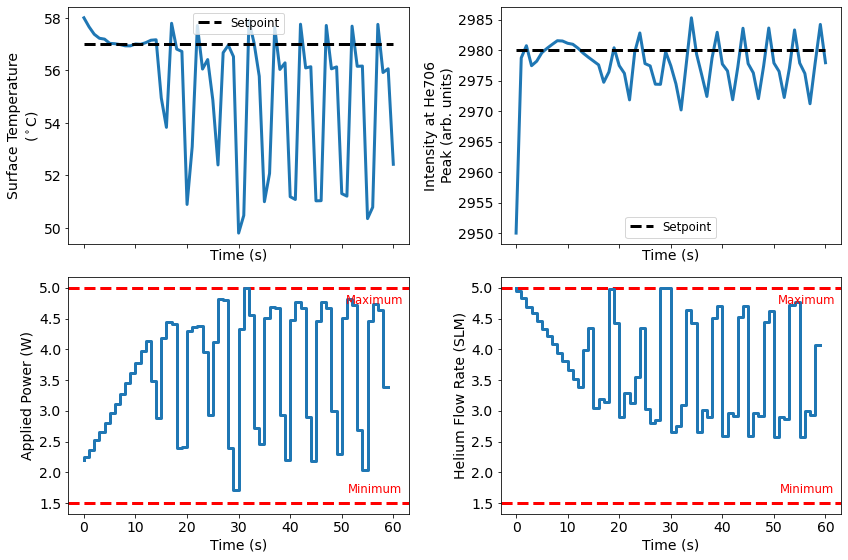



0.04   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37787059   0.03410612  -0.02903451]
 [-14.59977225   0.77176083  -0.53005923]
 [ 12.69106785   1.94928377  -1.39055204]]
B:  [[ 2.59990680e+00 -1.87191096e-01]
 [ 4.52996521e+02  4.98473431e+02]
 [ 6.58099508e+02  5.31718593e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


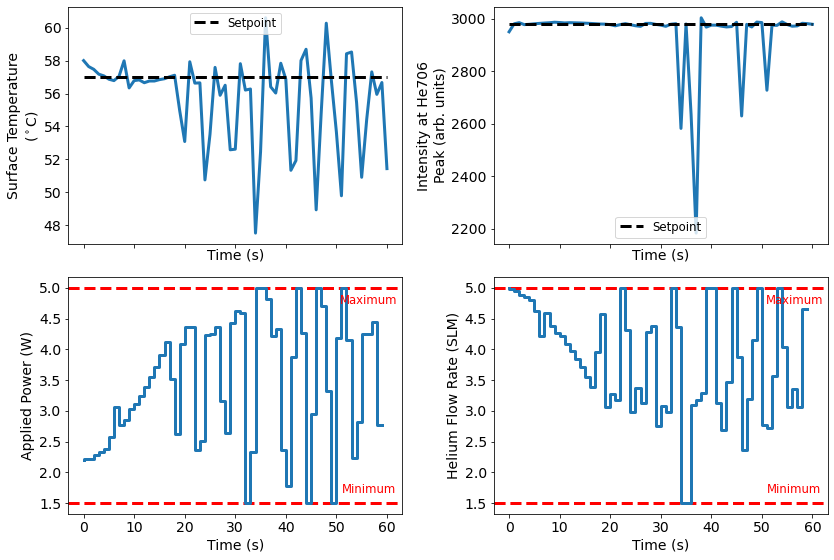



0.04   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37787059   0.03410612  -0.02903451]
 [-14.59977225   0.77176083  -0.53005923]
 [ 12.69106785   1.94928377  -1.39055204]]
B:  [[ 2.61239676e+00 -1.88342690e-01]
 [ 4.55486945e+02  5.01895865e+02]
 [ 6.64231905e+02  5.33226440e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

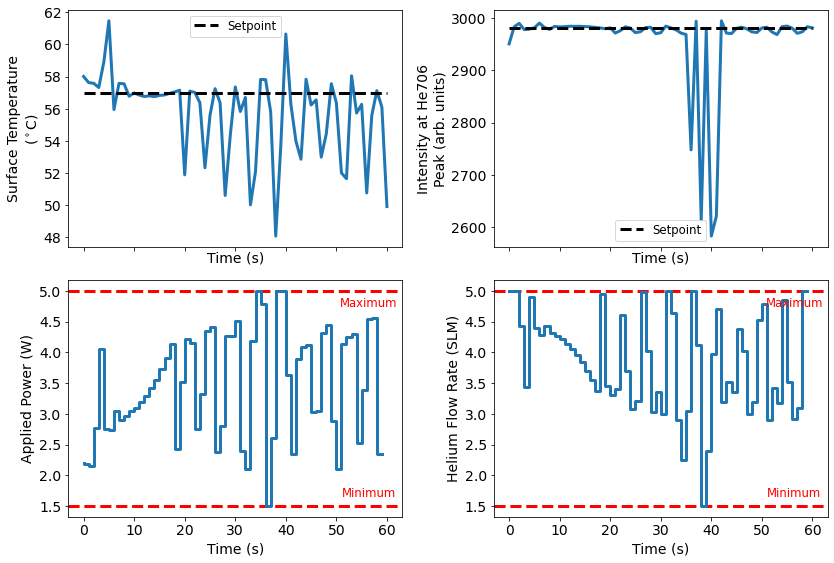



0.04   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37787059   0.03410612  -0.02903451]
 [-14.59977225   0.77176083  -0.53005923]
 [ 12.69106785   1.94928377  -1.39055204]]
B:  [[ 2.62488671e+00 -1.89494284e-01]
 [ 4.57977369e+02  5.05318299e+02]
 [ 6.70364302e+02  5.34734288e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

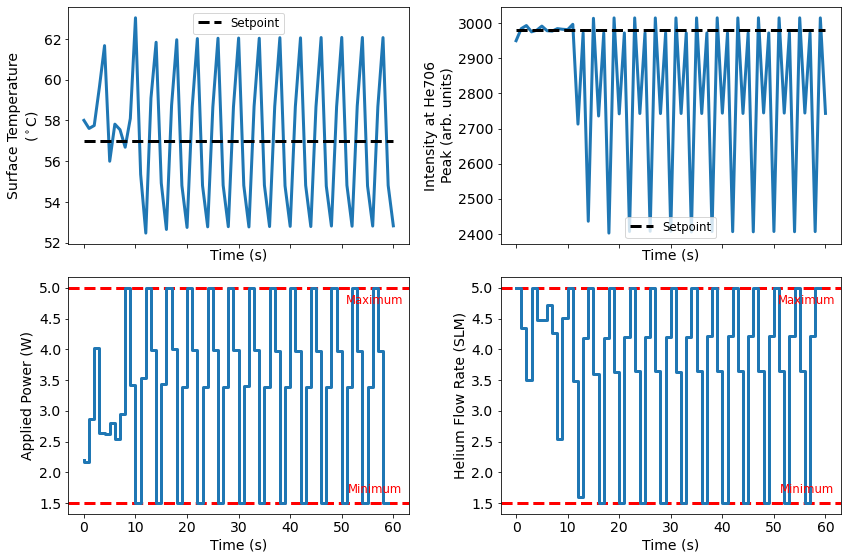



0.04   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37787059   0.03410612  -0.02903451]
 [-14.59977225   0.77176083  -0.53005923]
 [ 12.69106785   1.94928377  -1.39055204]]
B:  [[ 2.63737666e+00 -1.90645878e-01]
 [ 4.60467792e+02  5.08740733e+02]
 [ 6.76496699e+02  5.36242135e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

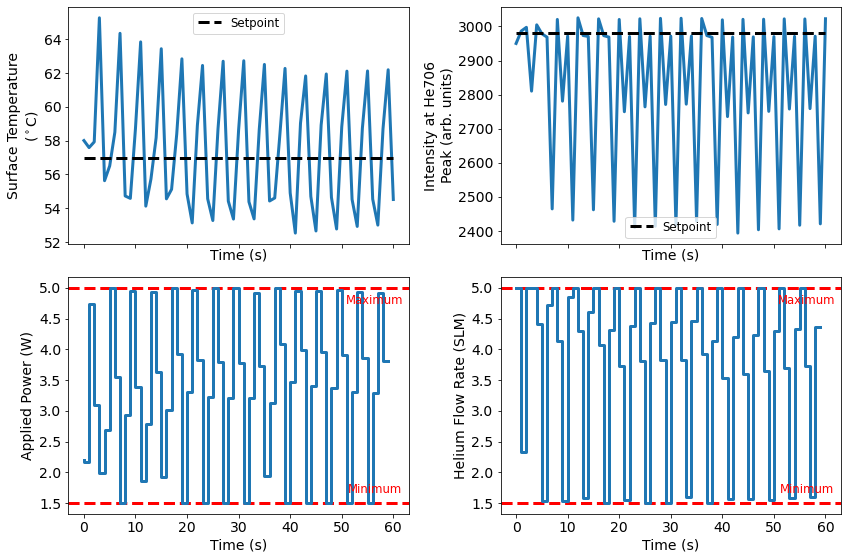



0.05   0.0 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37186626   0.03410609  -0.02927475]
 [-14.6399254    0.76926263  -0.53152977]
 [ 12.72441642   1.93685422  -1.37799719]]
B:  [[ 2.57492690e+00 -1.84887907e-01]
 [ 4.48015674e+02  4.91628563e+02]
 [ 6.45834714e+02  5.28702898e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.


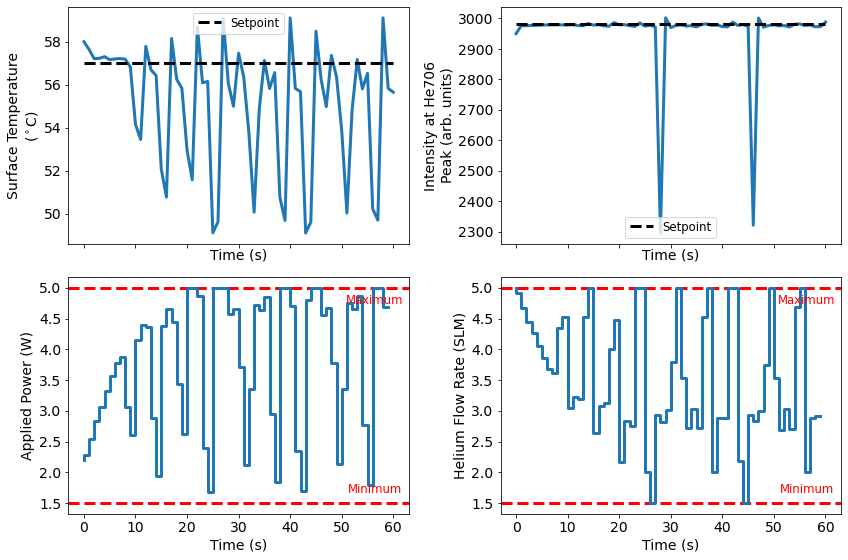



0.05   0.01 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37186626   0.03410609  -0.02927475]
 [-14.6399254    0.76926263  -0.53152977]
 [ 12.72441642   1.93685422  -1.37799719]]
B:  [[ 2.58741685e+00 -1.86039501e-01]
 [ 4.50506098e+02  4.95050997e+02]
 [ 6.51967111e+02  5.30210746e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

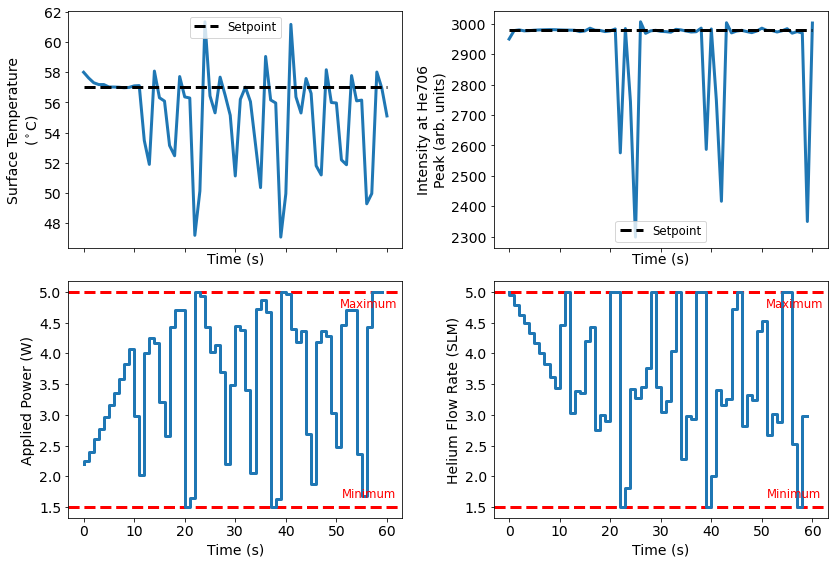



0.05   0.02 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37186626   0.03410609  -0.02927475]
 [-14.6399254    0.76926263  -0.53152977]
 [ 12.72441642   1.93685422  -1.37799719]]
B:  [[ 2.59990680e+00 -1.87191096e-01]
 [ 4.52996521e+02  4.98473431e+02]
 [ 6.58099508e+02  5.31718593e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

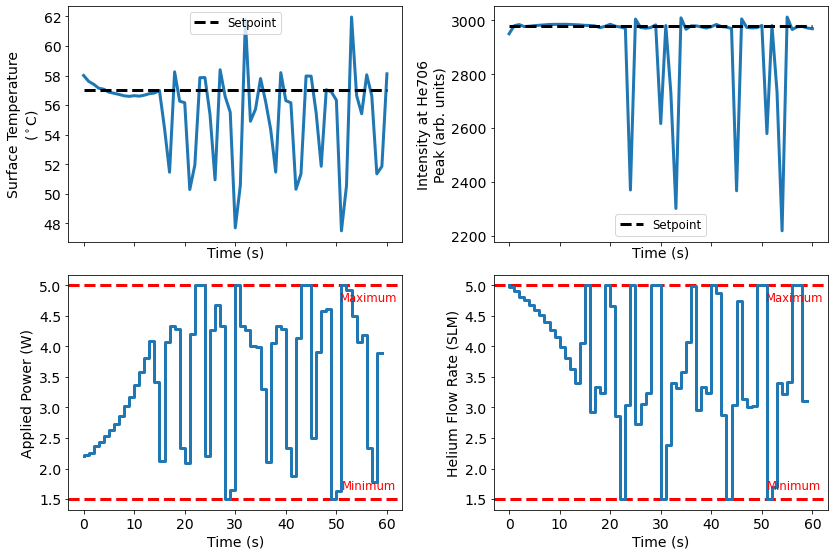



0.05   0.03 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37186626   0.03410609  -0.02927475]
 [-14.6399254    0.76926263  -0.53152977]
 [ 12.72441642   1.93685422  -1.37799719]]
B:  [[ 2.61239676e+00 -1.88342690e-01]
 [ 4.55486945e+02  5.01895865e+02]
 [ 6.64231905e+02  5.33226440e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

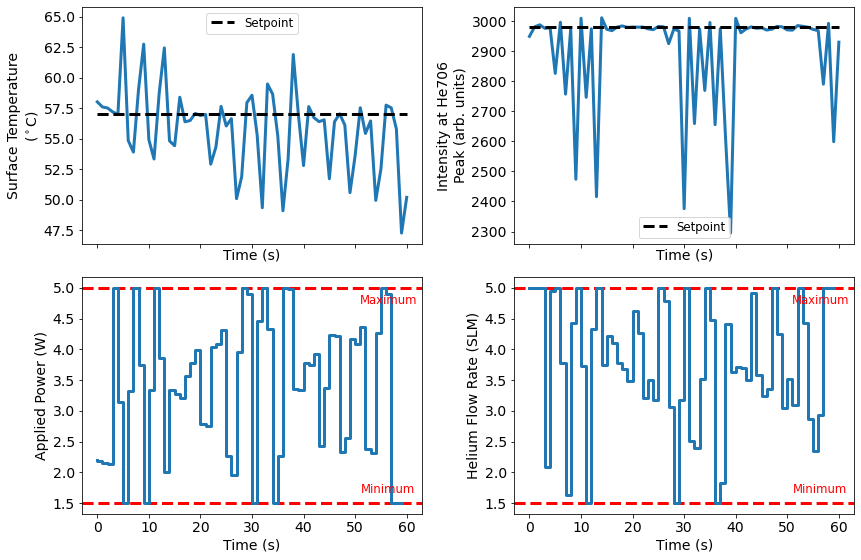



0.05   0.04 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37186626   0.03410609  -0.02927475]
 [-14.6399254    0.76926263  -0.53152977]
 [ 12.72441642   1.93685422  -1.37799719]]
B:  [[ 2.62488671e+00 -1.89494284e-01]
 [ 4.57977369e+02  5.05318299e+02]
 [ 6.70364302e+02  5.34734288e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

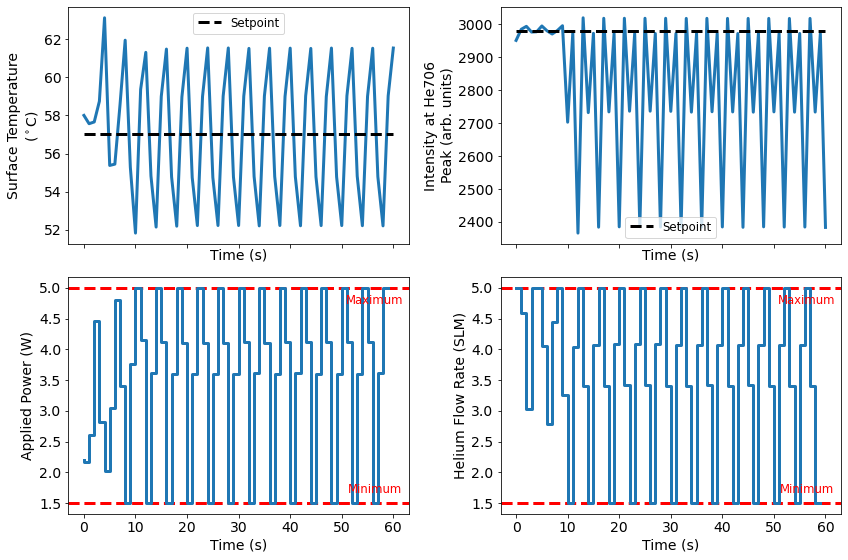



0.05   0.05 

Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.37186626   0.03410609  -0.02927475]
 [-14.6399254    0.76926263  -0.53152977]
 [ 12.72441642   1.93685422  -1.37799719]]
B:  [[ 2.63737666e+00 -1.90645878e-01]
 [ 4.60467792e+02  5.08740733e+02]
 [ 6.76496699e+02  5.36242135e+02]]
C:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
xss:  [  57.67095238 2733.14679525 4254.11606566]
50.0  target penalty applied and exists
Using a MPC.
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use 

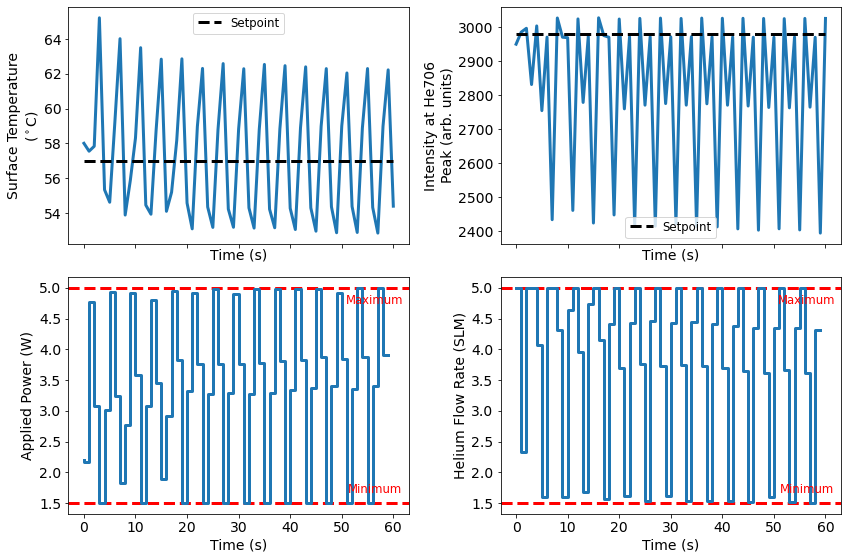

In [3]:
# testing sensitivity of A and B

for x1 in range(6):
    for x2 in range(6):
        div = 100
        print(x1/div, ' ', x2/div, '\n')
        
        perc = [x1/div,x2/div,1e-3,seed]
        T, I = run_mpc(perc, plt_fig=True)
        
        print('\n')

# loop through from 0 - 0.1 with stepsize 0.001 and see which values of perc1 and perc2 will not yield an output of infeasible result